# Import packages & functions

In [34]:
print("importing modules")
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

import utils

import importlib.util
parent_utils_path = "/home/ri4541/mindeye_preproc/analysis/utils.py"
spec = importlib.util.spec_from_file_location("utils", parent_utils_path)
preproc = importlib.util.module_from_spec(spec)
parent_dir = os.path.dirname(parent_utils_path)  # Extract directory
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
spec.loader.exec_module(preproc)

# Can run a SLURM job array to train many models with different random seed values
try:
    seed = int(os.environ["SLURM_ARRAY_TASK_ID"])
    print(f"using random seed {seed} in SLURM job {seed} of array")
except:
    print("SLURM random seed indices not provided; using random seed = 0")
    seed = 0

if utils.is_interactive():
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

importing modules
SLURM random seed indices not provided; using random seed = 0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Princeton data prep

## Load Data & Design

In [35]:
sub = 'sub-005'
session = 'all'
task='task-C_'  # '' (empty string) normally, task-A_ or similar otherwise
func_task_name = 'C'  # 'study' or 'A'; used to search for functional run in bids format
resample_voxel_size = False

# settings for multiple sessions
if session == "all":
    # ses_list = ["ses-01", "ses-02", "ses-03"]  # list of actual session IDs
    # design_ses_list = ["ses-01", "ses-02", "ses-03"]  # list of session IDs to search for design matrix
    ses_list = ["ses-01", "ses-03"]  # list of actual session IDs
    design_ses_list = ["ses-01", "ses-03"]  # list of session IDs to search for design matrix

else:
    ses_list = [session]
    design_ses_list = [session]
    
multi_session = False  # do you want to run GLMsingle on multiple sessions for this subject? 
ref_session = None  # None or 'ses-xx'; use the T1 from the reference session; use this only if the current session doesn't have a T1
if ref_session is not None: 
    assert multi_session is True
if ref_session is None: ref_session = session

if sub=='sub-001' and session == 'ses-01':
    n_runs=16
elif sub=='sub-002' and session == 'ses-01':
    n_runs=9
elif (sub=='sub-001' and session in ('ses-05')) or (sub=='sub-002' and session in ('ses-02')) or (sub=='sub-004' and session in ('ses-01')):
    n_runs=5
elif sub=='sub-004' and session  == 'ses-02':
    n_runs = 12
elif sub=='sub-004' and session == 'all':
    n_runs = 17
    runs_per_session = {
    "ses-01": 5,
    "ses-02": 12
    }
elif sub=='sub-005' and session in ('ses-01', 'ses-02', 'ses-03'):
    n_runs=11
elif sub=='sub-005' and session == 'all':
    runs_per_session = {
    "ses-01": 11,
    "ses-02": 11,
    "ses-03": 11
    }
    n_runs = sum(runs_per_session[ses] for ses in ses_list)
else:
    raise Exception("undefined subject and/or session")
runs_per_session = {session: n_runs} if not multi_session else runs_per_session
if multi_session: assert runs_per_session is not None
print(n_runs, "functional runs")
train_test_split = 'MST' # 'orig'
remove_close_to_MST = False
remove_random_n = False
# if remove_close_to_MST or remove_random_n:
#     assert remove_close_to_MST != remove_random_n  # don't remove both sets of images

# if remove_random_n:
#     assert train_test_split == 'MST'  # MST images are excluded from the n images removed, so only makes sense if they're not in the training set
#     n_to_remove = 150

22 functional runs


In [36]:
session_label = preproc.get_session_label(ses_list[:-1])

In [37]:
glmsingle_path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{session_label}_task-{func_task_name}"
print(glmsingle_path)
assert os.path.exists(glmsingle_path)
designdir = "/home/ri4541/real_time_mindEye2"

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C


In [38]:
def get_image_pairs(sub, session, func_task_name, designdir):
    """Loads design files and processes image pairs for a given session."""
    _, _, _, _, image_names, unique_images, _ = preproc.load_design_files(
        sub=sub,
        session=session,
        func_task_name=func_task_name,
        designdir=designdir,
        design_ses_list=[session]  # Ensure it's a list
    )
    return utils.process_images(image_names, unique_images)

In [39]:
pairs_list = []

if len(ses_list) > 2:
    # Case 1: Aggregate results from multiple sessions (ses_list[:-1]), concatenating into a single list
    combined_pairs = sum([get_image_pairs(sub, s, func_task_name, designdir)[-1] for s in ses_list[:-1]], [])
    pairs_list.append(combined_pairs)

    # Case 2: Process last session separately
    pairs_list.append(get_image_pairs(sub, ses_list[-1], func_task_name, designdir)[-1])

else:
    # Case 3: Process both sessions individually if ses_list has only 2 entries
    pairs_list.extend([get_image_pairs(sub, s, func_task_name, designdir)[-1] for s in ses_list])

assert len(pairs_list) == 2

Data shape: (780, 122)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-01.csv
Total number of images: 770
Number of unique images: 532
Data shape: (780, 126)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532


In [40]:
def get_betas(path):
    glmsingle = np.load(path, allow_pickle=True) 
    return glmsingle['betasmd'].T

### Load nsdgeneral ROI

session masks, avg_mask, nsdgeneral roi, final mask all in the same space!
Mask dimensions: (2.0, 2.0, 2.0)

Affine:
[[  2.           0.           0.         -76.29234314]
 [  0.           2.           0.         -84.79180908]
 [  0.           0.           2.         -62.80359268]
 [  0.           0.           0.           1.        ]]

There are 180585 voxels in the included brain mask



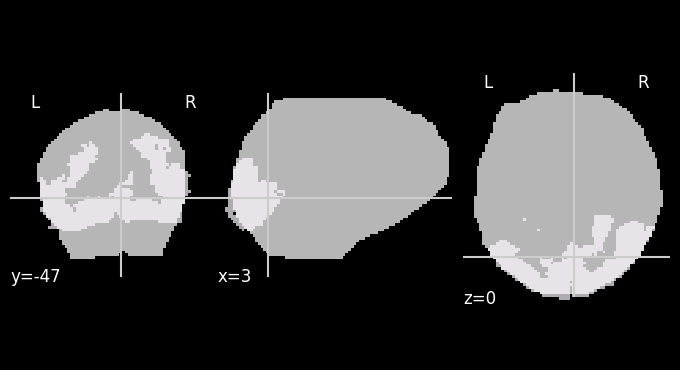

In [41]:
from nilearn.plotting import plot_roi, plot_anat, plot_epi
from nilearn.masking import intersect_masks
import nilearn

# avg_mask=nib.load(f'{sub}_ses-01_brain.nii.gz')
assert sub == 'sub-005' and session == "all"
# if len(ses_list) == 2:
#         print('creating multisession brain mask')
#         func_masks, avg_mask, nsd_masks, roi = utils.get_mask(ses_list, sub, func_task_name)
# else:
#     assert len(ses_list) > 2
#     print('loading brain mask')
#     func_masks, avg_mask, nsd_masks, roi = utils.get_mask([session_label, ses_list[-1]], sub, func_task_name)

avg_mask = nib.load('/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_task-C/sub-005_final_brain.nii.gz')
roi = nib.load('/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_task-C/sub-005_final_nsdgeneral.nii.gz')
final_mask = nib.load('/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_task-C/sub-005_final_mask.nii.gz')
ses_masks = []
for s in ses_list:
    ses_masks.append(nib.load(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_{s}_task-C/sub-005_{s}_task-C_brain.nii.gz'))

masks = [avg_mask, roi, final_mask] + ses_masks
for mask in masks:
    assert np.all(mask.affine == masks[0].affine)
    assert np.all(mask.shape == masks[0].shape)
    
print('session masks, avg_mask, nsdgeneral roi, final mask all in the same space!')

# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {int(np.sum(brain))} voxels in the included brain mask\n')

plot_roi(roi, bg_img=avg_mask)
plt.show()

In [42]:
if session == "all" and len(ses_list) == 2:
    vox_list = []
    for s in ses_list:
        path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{s}_task-{func_task_name}/TYPED_FITHRF_GLMDENOISE_RR.npz"
        vox_list.append(get_betas(path))
        
        print(f"Loaded session: {s} | Current shape: {vox_list[-1].shape}")
else:
    assert len(ses_list) > 2
    vox_list = []
    path = f"{glmsingle_path}/TYPED_FITHRF_GLMDENOISE_RR.npz"
    vox_list.append(get_betas(path))
    print(f"Loaded session: {session_label} | Current shape: {vox_list[-1].shape}")
    path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{ses_list[-1]}_task-{func_task_name}/TYPED_FITHRF_GLMDENOISE_RR.npz"
    vox_list.append(get_betas(path))
    print(f"Loaded session: {ses_list[-1]} | Current shape: {vox_list[-1].shape}")

Loaded session: ses-01 | Current shape: (693, 1, 1, 182242)
Loaded session: ses-03 | Current shape: (693, 1, 1, 183408)


In [43]:
# def get_masked_betas(ses_list, vox_list, func_masks, avg_mask, roi):
#     masked_betas = []
#     for i, s in enumerate(vox_list):
#         v = nilearn.masking.unmask(vox_list[i][:,0,0], func_masks[i])
#         final_mask = nilearn.masking.intersect_masks([avg_mask, roi])
#         masked_betas.append(nilearn.masking.apply_mask(v, final_mask))
        
#     vox = np.concatenate(masked_betas)
#     print('vox shape:', vox.shape)
    
#     return final_mask, masked_betas, vox

In [44]:
# if session == 'all':
#     assert len(vox_list) == 2
#     final_mask, masked_betas, vox = get_masked_betas(ses_list, vox_list, func_masks, avg_mask, roi)
# # elif len(ses_list) > 2:
# #     final_mask, masked_betas, vox = get_masked_betas(ses_list[:-1], vox_list, func_masks, avg_mask, roi)

In [45]:
if session == 'all':
    ses_vox = []
    for i, s in enumerate(ses_list):
        if ses_list == ['ses-01', 'ses-02', 'ses-03'] and session_label == 'ses-01-02' and i == 2:  # skip the 3rd iteration since there's only 2 items to go through in vox_list: ses-01-02 and ses-03 betas
            continue
        v = nilearn.masking.unmask(vox_list[i][:,0,0], ses_masks[i])  # move back to 3D based on own session mask
        # final_mask = nilearn.masking.intersect_masks([avg_mask, roi])
        ses_vox.append(nilearn.masking.apply_mask(v, final_mask))  # re-flatten based on final mask so everything is in the same shape now
        
    vox = np.concatenate(ses_vox)
    print('vox shape:', vox.shape)

vox shape: (1386, 19174)


In [46]:
def get_pairs(data, repeat_indices=(0, 1)):
    """
    Extract pairs based on specified repeat indices, falling back to available repeats.
    
    Parameters:
    - data: List of items, where each item may have different number of repeats
    - repeat_indices: Tuple of indices (i, j) to extract if available
    
    Returns:
    - Array of pairs
    """
    result = []
    
    for item in data:
        # Determine what repeats are actually available
        num_repeats = len(item)
        
        # Handle the requested indices
        i, j = repeat_indices
        
        # Adjust indices if they're out of bounds
        if i >= num_repeats:
            i = min(num_repeats - 1, 0)
        if j >= num_repeats:
            j = min(num_repeats - 1, 1 if num_repeats > 1 else 0)
        if i == j:
            i = 0
            j = 1
        # Create the pair
        result.append([item[i], item[j]])
    
    return np.array(result)

In [47]:
def compute_vox_rels(vox, pairs, sub, session, r, plot=True):
    pairs = get_pairs(pairs, repeat_indices=r)

    vox_pairs = utils.zscore(vox[pairs])
    rels = np.full(vox.shape[-1], np.nan)
    for v in tqdm(range(vox.shape[-1])):
        rels[v] = np.corrcoef(vox_pairs[:, 0, v], vox_pairs[:, 1, v])[1, 0]
    
    print("rels", rels.shape)
    assert np.sum(np.all(np.isnan(rels))) == 0
    
    vox0 = np.zeros((len(pairs), vox.shape[-1], 2))
    for ipair, pair in enumerate(tqdm(pairs)):
        i, j = pair[:2]  # Using the first two repeats
        vox0[ipair, :, :] = vox[pair].T
    vox_avg = vox0.mean(-1)
    
    r_thresholds = np.array([.2])
    rdm = np.zeros((len(r_thresholds), len(pairs), len(pairs))) 
    for ir_thresh, r_thresh in enumerate(r_thresholds):
        print(f"reliability threshold = {r_thresh}")
        for i in tqdm(range(len(pairs))):
            for j in range(len(pairs)):
                rdm[ir_thresh, i, j] = np.corrcoef(vox_avg[i, rels > r_thresh], 
                                                   vox_avg[j, rels > r_thresh])[0, 1]
                if i == j:
                    tmp = np.corrcoef(vox_avg[i, rels > r_thresh], 
                                                   vox_avg[j, rels > r_thresh])[0, 1]
                    assert np.isclose(tmp, 1)
    if plot:
        thresh = .2
        plt.figure(figsize=(4, 4))
        plt.imshow(rdm[np.where(r_thresholds == thresh)[0].item()], clim=(-1, 1))
        plt.colorbar(shrink=0.8)
        plt.title(f"{sub}_{session}\nreliability threshold={thresh}; repeats {r}")
        plt.show()
    
    for thresh in range(rdm.shape[0]):
        for img in range(rdm.shape[1]):
            assert np.isclose(rdm[thresh, img, img], 1)
    
    return rels

In [48]:
# pairs_list[0][112:][:10]

In [49]:
# get_pairs(pairs_list[0][112:][:10], (1,2))

(693, 19174)


100%|██████████| 19174/19174 [00:01<00:00, 18600.25it/s]


rels (19174,)


100%|██████████| 112/112 [00:00<00:00, 5944.32it/s]


reliability threshold = 0.2


100%|██████████| 112/112 [00:01<00:00, 60.77it/s]


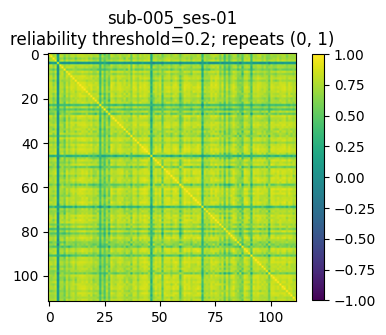

100%|██████████| 19174/19174 [00:01<00:00, 18560.37it/s]


rels (19174,)


100%|██████████| 112/112 [00:00<00:00, 6116.22it/s]


reliability threshold = 0.2


100%|██████████| 112/112 [00:01<00:00, 60.33it/s]


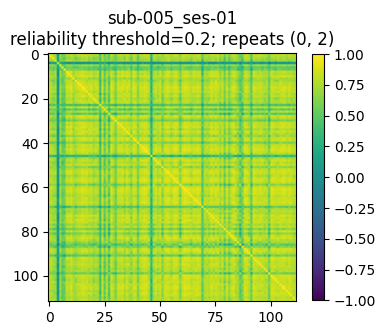

100%|██████████| 19174/19174 [00:01<00:00, 18349.31it/s]


rels (19174,)


100%|██████████| 112/112 [00:00<00:00, 5174.39it/s]


reliability threshold = 0.2


100%|██████████| 112/112 [00:01<00:00, 59.67it/s]


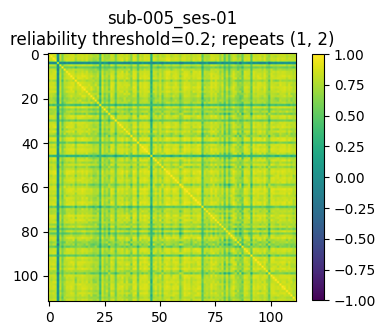

(693, 19174)


100%|██████████| 19174/19174 [00:01<00:00, 18808.73it/s]


rels (19174,)


100%|██████████| 112/112 [00:00<00:00, 6044.37it/s]


reliability threshold = 0.2


100%|██████████| 112/112 [00:01<00:00, 64.78it/s]


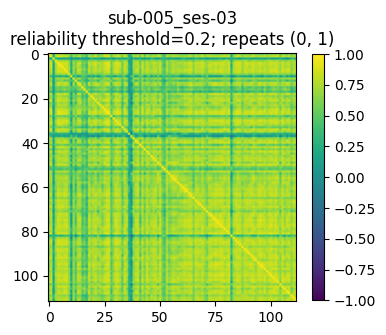

100%|██████████| 19174/19174 [00:01<00:00, 18550.27it/s]


rels (19174,)


100%|██████████| 112/112 [00:00<00:00, 5922.07it/s]


reliability threshold = 0.2


100%|██████████| 112/112 [00:01<00:00, 65.92it/s]


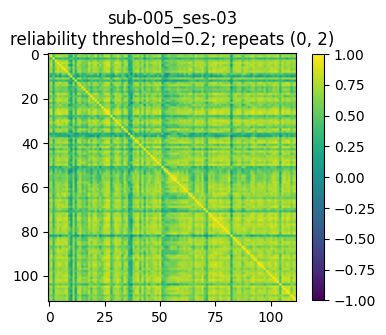

100%|██████████| 19174/19174 [00:01<00:00, 18681.64it/s]


rels (19174,)


100%|██████████| 112/112 [00:00<00:00, 5807.42it/s]


reliability threshold = 0.2


100%|██████████| 112/112 [00:01<00:00, 64.45it/s]


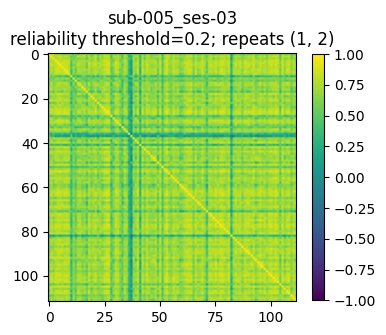

In [50]:
split_session = False
ses_rels = []
repeat_combinations = [(0, 1), (0, 2), (1, 2)]
if split_session:
    assert ses_list == ['ses-01', 'ses-02', 'ses-03'] and session_label == 'ses-01-02'
    for i, s in enumerate(ses_list):
        # print(ses_vox[i].shape)

        # Calculate relationships for each combination of repeats
        combo_rels = []
        for combo in repeat_combinations:
            try:
                if i == 0:
                    print(ses_vox[0][:693].shape)
                    rel = compute_vox_rels(ses_vox[0][:693], pairs_list[0][:112], sub, 'ses-01', combo)
                elif i == 1:
                    print(ses_vox[0][693:].shape)
                    if combo == (0,1):
                        continue
                    rel = compute_vox_rels(ses_vox[0][693:], pairs_list[0][112:], sub, 'ses-02', combo)
                elif i == 2:
                    print(ses_vox[1].shape)
                    rel = compute_vox_rels(ses_vox[1], pairs_list[1], sub, s, combo)
                else:
                    raise ValueError
                combo_rels.append(rel)
            except IndexError:
                # Skip combinations that aren't available (e.g., if only 2 repeats exist)
                continue

        # Average the relationships across all valid combinations
        if combo_rels:
            avg_rel = np.mean(combo_rels, axis=0)
            ses_rels.append(avg_rel)
        else:
            # Fallback to original behavior if no combinations worked
            rels = compute_vox_rels(ses_vox[i], pairs_list[i], sub, s, (0, 1))
            ses_rels.append(rels)
else:
    for i, s in enumerate([session_label, ses_list[-1]]):
        print(ses_vox[i].shape)

        # Calculate relationships for each combination of repeats
        combo_rels = []
        for combo in repeat_combinations:
            try:
                rel = compute_vox_rels(ses_vox[i], pairs_list[i], sub, s, combo)
                combo_rels.append(rel)
            except IndexError:
                # Skip combinations that aren't available (e.g., if only 2 repeats exist)
                continue

        # Average the relationships across all valid combinations
        if combo_rels:
            avg_rel = np.mean(combo_rels, axis=0)
            ses_rels.append(avg_rel)
        else:
            # Fallback to original behavior if no combinations worked
            rels = compute_vox_rels(ses_vox[i], pairs_list[i], sub, s, (0, 1))
            ses_rels.append(rels)

In [51]:
for s in ses_rels: 
    print(s.min(), s.max(), s.mean(), s.std())

-0.27915276583950366 0.6615490701608286 0.06289714403413385 0.1321660479434072
-0.28358294387561706 0.6228058268898707 0.05357403154649009 0.11396921717679594


threshold -0.2: 19110 voxels
threshold -0.1: 17882 voxels
threshold 0.0: 12540 voxels
threshold 0.1: 5971 voxels
threshold 0.2: 2591 voxels
threshold 0.3: 1219 voxels
threshold 0.4: 485 voxels
threshold 0.5: 133 voxels


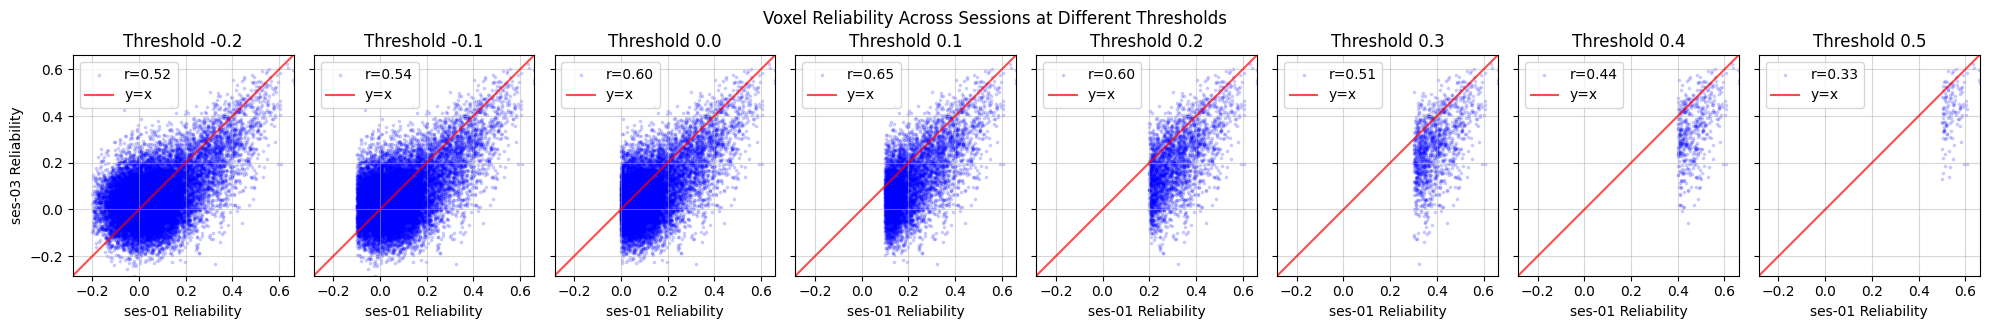

In [52]:
from matplotlib.ticker import MaxNLocator

r_thresholds = np.arange(-0.2, 0.6, 0.1)

# Determine global axis limits
reliability_min = min(ses_rels[0].min(), ses_rels[-1].min())
reliability_max = max(ses_rels[0].max(), ses_rels[-1].max())

# Create subplots
fig, axes = plt.subplots(1, len(r_thresholds), figsize=(20,3), sharex=True, sharey=True)

masks = []
for i, thresh in enumerate(r_thresholds):
    mask = ses_rels[0] > thresh
    masks.append(mask)
    x = ses_rels[0][mask]  # threshold reliability based on ses-01
    y = ses_rels[-1][mask]  # compare to ses-02 reliabilities but using the ses-01 threshold
    print(f"threshold {thresh:.1f}: {x.shape[0]} voxels")
    
    assert x.shape == y.shape
    corr = np.corrcoef(x,y)[0,1]
    
    # Scatter plot
    axes[i].scatter(x, y, alpha=0.15, s=3, color='blue', label=f'r={corr:.2f}')
    
    axes[i].axline((0, 0), slope=1, color='r', alpha=0.7, label="y=x")

    # Set square aspect ratio and equal axis limits
    axes[i].set_xlim(reliability_min, reliability_max)
    axes[i].set_ylim(reliability_min, reliability_max)
    axes[i].set_aspect('equal', adjustable='box')  # Ensures square plots

    # Set tick marks to be evenly spaced
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5))

    # Labels and title
    axes[i].set_title(f"Threshold {thresh:.1f}")
    axes[i].set_xlabel(f"{session_label} Reliability")
    if i == 0:
        axes[i].set_ylabel(f"{ses_list[-1]} Reliability")
    
    axes[i].legend()
    axes[i].grid(alpha=0.5)

plt.suptitle("Voxel Reliability Across Sessions at Different Thresholds")
plt.tight_layout()
plt.show()

12673 voxels in ses-03 with reliability > 0.0 (no threshold)
5465 voxels in ses-03 with reliability > 0.1 (no threshold)
1864 voxels in ses-03 with reliability > 0.2 (no threshold)
686 voxels in ses-03 with reliability > 0.3 (no threshold)
227 voxels in ses-03 with reliability > 0.4 (no threshold)


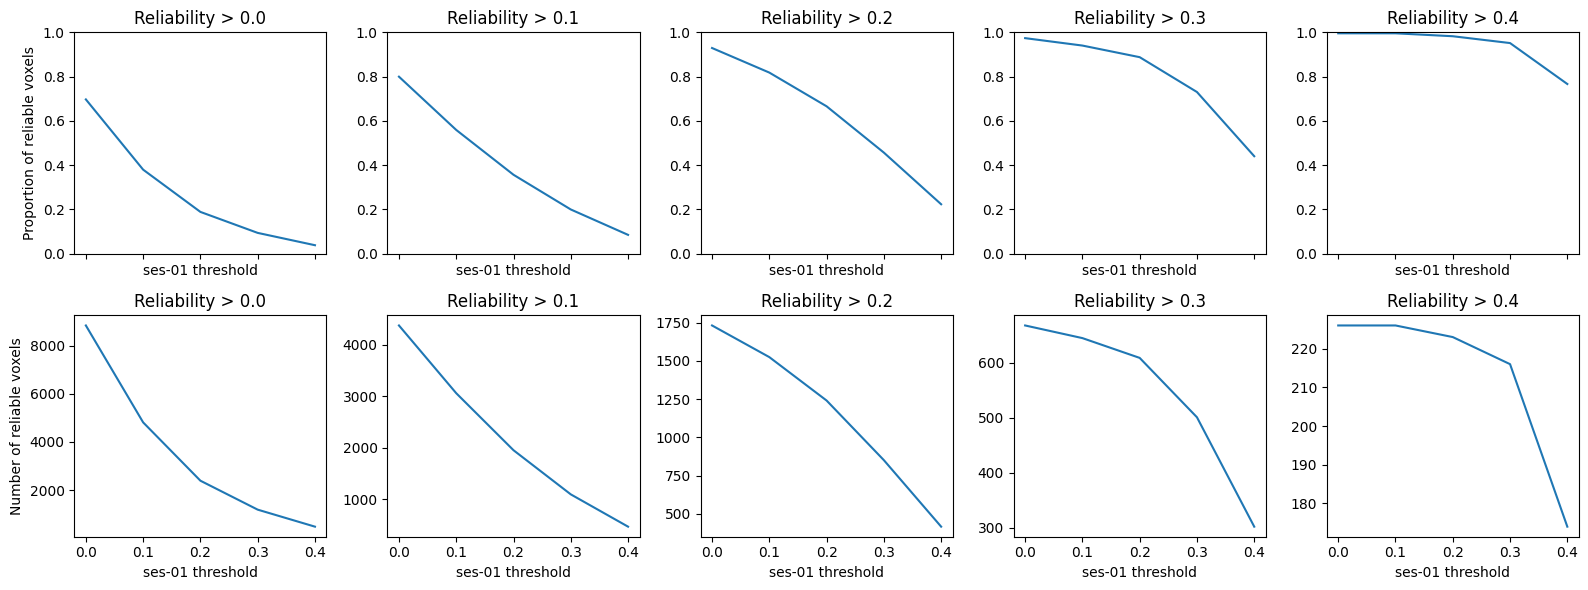

In [53]:
# x_thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
x_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]
y_thresholds = x_thresholds

x = ses_rels[0]
y = ses_rels[-1]

fig, ax = plt.subplots(2, len(x_thresholds), figsize=(16, 6), sharex=True)

for i, y_thresh in enumerate(y_thresholds):
    baseline = np.sum(y > y_thresh)
    print(f'{baseline} voxels in ses-03 with reliability > {y_thresh} (no threshold)')

    all_prop, all_num = [], []
    for x_thresh in x_thresholds:
        num = np.sum(y[np.where(x > x_thresh)] > y_thresh)
        all_prop.append(num / baseline)
        all_num.append(num)

    # Plot proportion
    ax[0, i].plot(x_thresholds, all_prop)
    ax[1, i].plot(x_thresholds, all_num)

    for j, label in enumerate(["Proportion of reliable voxels", "Number of reliable voxels"]):
        ax[j, i].set_title(f'Reliability > {y_thresh}')
        ax[j, i].set_xlabel(f'{session_label} threshold')
        if i == 0:
            ax[j, i].set_ylabel(label)

    for a in ax[0, :]:  
        a.set_ylim(0, 1)

plt.tight_layout()
plt.show()

12673 voxels with reliability > 0.4 without on/off r^2 threshold
5465 voxels with reliability > 0.4 without on/off r^2 threshold
1864 voxels with reliability > 0.4 without on/off r^2 threshold
686 voxels with reliability > 0.4 without on/off r^2 threshold
227 voxels with reliability > 0.4 without on/off r^2 threshold


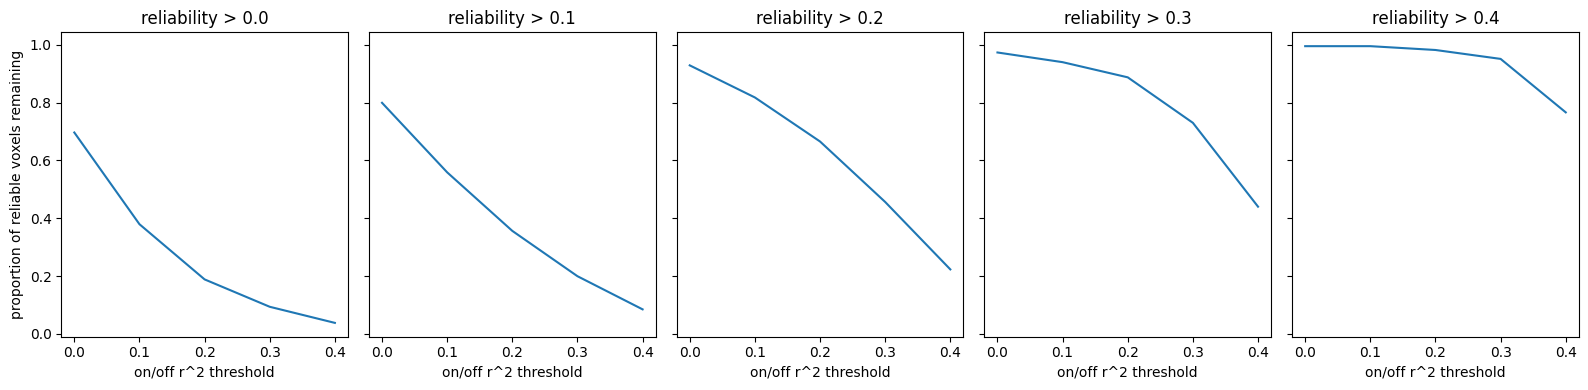

In [54]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
for i, y_thresh in enumerate(y_thresholds):
    baseline = np.sum(y>y_thresh)  # how many voxels are reliable (r > 0.2) without an on/off r^2 threshold? 
    print(f'{baseline} voxels with reliability > {x_thresh} without on/off r^2 threshold')
    all_prop = []
    for x_thresh in x_thresholds:
        num = np.sum(y[np.where(x>x_thresh)]>y_thresh)
        # print(num)
        prop = num/baseline
        # print(f'{prop:.2%} voxels with reliability > {rel_thresh} at on/off r^2 > {r2_thresh}')
        # print(f'{thresh:.2f}: {prop:.2%} ({x[mask].shape[0]})')
        all_prop.append(prop)
    ax[i].plot(x_thresholds, all_prop)
    ax[i].set_xlabel('on/off r^2 threshold')
    if i == 0:
        ax[i].set_ylabel('proportion of reliable voxels remaining')
    ax[i].set_title(f'reliability > {y_thresh}')
plt.tight_layout()
plt.show()

12673 voxels in ses-03 with reliability > 0.0 without threshold
5465 voxels in ses-03 with reliability > 0.1 without threshold
1864 voxels in ses-03 with reliability > 0.2 without threshold
686 voxels in ses-03 with reliability > 0.3 without threshold
227 voxels in ses-03 with reliability > 0.4 without threshold


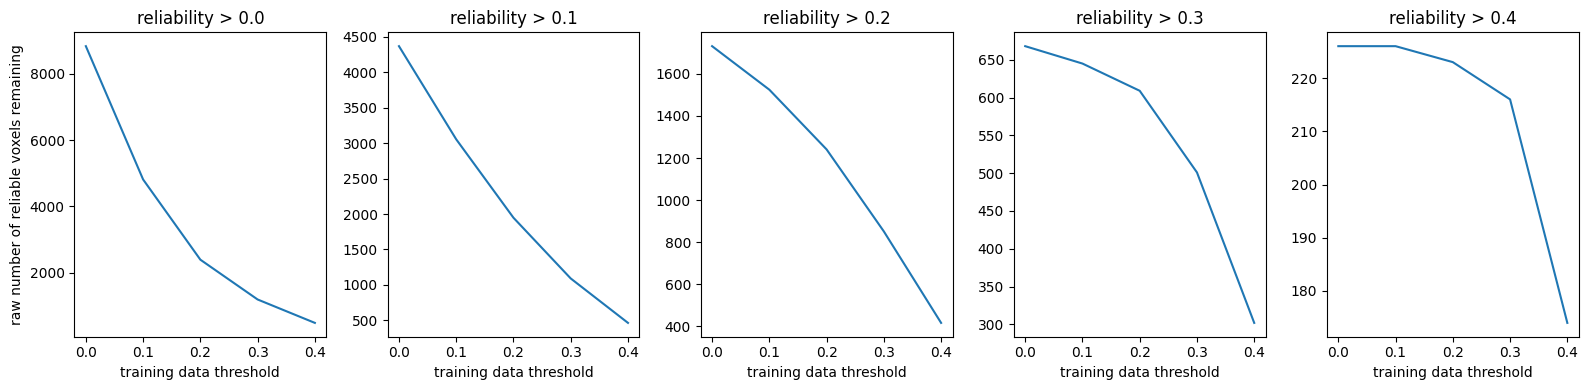

In [55]:
# how many of the reliable voxels from the held-out session remain at each threshold? 
fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=False)
for i, y_thresh in enumerate(y_thresholds):
    baseline = np.sum(y>y_thresh)  # how many voxels are reliable (r > 0.2) without a threshold on y? 
    print(f'{baseline} voxels in ses-03 with reliability > {y_thresh} without threshold')
    all_num = []
    for x_thresh in x_thresholds:
        num = np.sum(y[np.where(x>x_thresh)]>y_thresh)
        all_num.append(num)
    ax[i].plot(x_thresholds, all_num)
    ax[i].set_xlabel('training data threshold')
    if i == 0:
        ax[i].set_ylabel('raw number of reliable voxels remaining')
    ax[i].set_title(f'reliability > {y_thresh}')
plt.tight_layout()
plt.show()

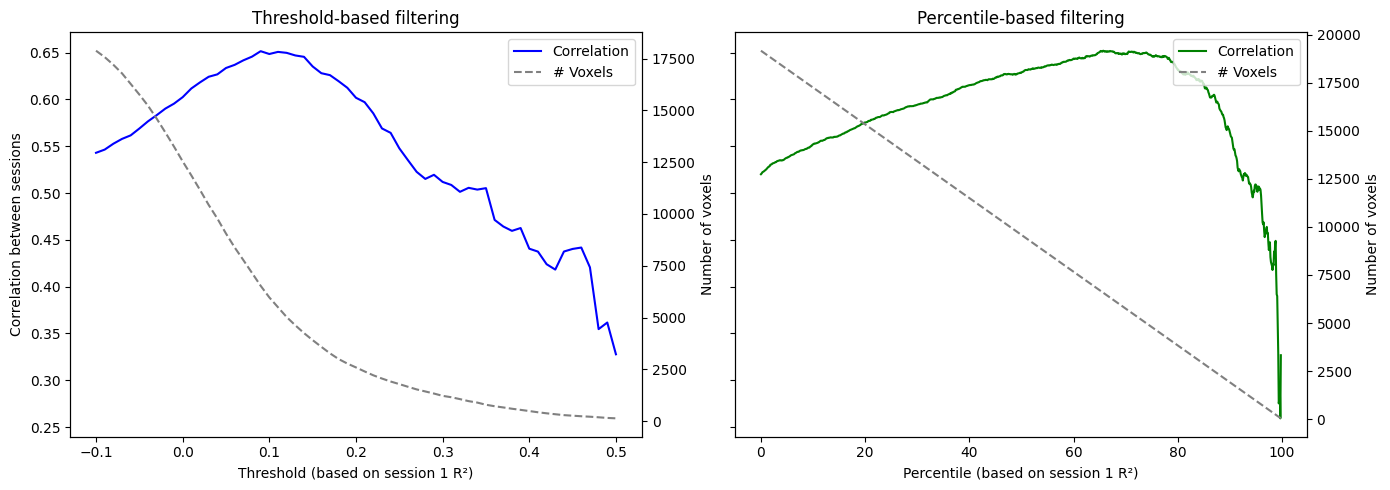

Best threshold: 0.09
r = 0.65
# voxels included = 6532

Best percentile: 65.70
r = 0.65
# voxels included = 6577


In [56]:
# Reliability values from two sessions
x = ses_rels[0]
y = ses_rels[-1]

thresholds = np.arange(-0.1, 0.51, 0.01)

corrs_thresh = []
nvox_thresh = []

percentile_masks = []

for thresh in thresholds:
    mask = x > thresh
    x_masked = x[mask]
    y_masked = y[mask]

    if len(x_masked) > 1:
        corr = np.corrcoef(x_masked, y_masked)[0, 1]
    else:
        corr = np.nan

    corrs_thresh.append(corr)
    nvox_thresh.append(np.sum(mask))

percentiles = np.arange(0, 99.9, .1)

corrs_percentile = []
nvox_percentile = []

for p in percentiles:
    thresh = np.percentile(x, p)
    mask = x > thresh
    percentile_masks.append(mask)
    x_masked = x[mask]
    y_masked = y[mask]

    if len(x_masked) > 1:
        corr = np.corrcoef(x_masked, y_masked)[0, 1]
    else:
        corr = np.nan

    corrs_percentile.append(corr)
    nvox_percentile.append(np.sum(mask))

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Threshold-based
axs[0].plot(thresholds, corrs_thresh, label='Correlation', color='blue')
axs[0].set_xlabel('Threshold (based on session 1 R²)')
axs[0].set_ylabel('Correlation between sessions')
axs0b = axs[0].twinx()
axs0b.plot(thresholds, nvox_thresh, label='# Voxels', color='gray', linestyle='--')
axs0b.set_ylabel('Number of voxels')
axs[0].set_title('Threshold-based filtering')
lines1, labels1 = axs[0].get_legend_handles_labels()
lines2, labels2 = axs0b.get_legend_handles_labels()
axs[0].legend(lines1 + lines2, labels1 + labels2, loc='upper right')


# Percentile-based
axs[1].plot(percentiles, corrs_percentile, label='Correlation', color='green')
axs[1].set_xlabel('Percentile (based on session 1 R²)')
axs1b = axs[1].twinx()
axs1b.plot(percentiles, nvox_percentile, label='# Voxels', color='gray', linestyle='--')
axs1b.set_ylabel('Number of voxels')
axs[1].set_title('Percentile-based filtering')
lines1, labels1 = axs[1].get_legend_handles_labels()
lines2, labels2 = axs1b.get_legend_handles_labels()
axs[1].legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

best_idx_thresh = np.nanargmax(corrs_thresh)
print(f"Best threshold: {thresholds[best_idx_thresh]:.2f}")
print(f"r = {corrs_thresh[best_idx_thresh]:.2f}")
print(f"# voxels included = {nvox_thresh[best_idx_thresh]}")

best_idx_percentile = np.nanargmax(corrs_percentile)
print(f"\nBest percentile: {percentiles[best_idx_percentile]:.2f}")
print(f"r = {corrs_percentile[best_idx_percentile]:.2f}")
print(f"# voxels included = {nvox_percentile[best_idx_percentile]}")

In [57]:
percentile_masks[best_idx_percentile].shape

(19174,)

In [58]:
p = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_task-C/rel_mask_from_{session_label}_to_{ses_list[-1]}.npy"
np.save(p, percentile_masks[best_idx_percentile])
print(f'saved reliability mask to {p}!')

saved reliability mask to /scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_task-C/rel_mask_from_ses-01_to_ses-03.npy!


In [59]:
err

NameError: name 'err' is not defined

In [ ]:
np.mean(reliable_vox0, axis=0).shape

In [ ]:
np.mean(reliable_vox0, axis=0)

In [ ]:
x = np.mean(reliable_vox0, axis=0)
y = np.mean(reliable_vox1, axis=0)

# Scatterplot
plt.figure(figsize=(7, 6))
plt.scatter(x, y, alpha=0.6, edgecolors='k')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), label='best fit')
plt.xlabel("Voxelwise Reliability (Session 1)")
plt.ylabel("Voxelwise Reliability (Session 2)")
plt.title("Voxelwise Reliability Across Sessions")
plt.axline((0, 0), slope=1, color='r', linestyle="--", label="y=x (Perfect Agreement)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
reliability_min = min(ses_rels[0].min(), ses_rels[1].min())
reliability_max = max(ses_rels[0].max(), ses_rels[1].max())

# Create subplots
fig, axes = plt.subplots(1, len(r_thresholds), figsize=(15, 4), sharex=True, sharey=True)

for i, thresh in enumerate(r_thresholds):
    # Select voxels that pass the threshold
    mask = ses_rels[0] > thresh
    x_thresh = ses_rels[0][mask]  # Reliability from session 0
    y_thresh = ses_rels[1][mask]  # Corresponding reliability from session 1

    # Compute correlation
    corr_coef = np.corrcoef(x_thresh, y_thresh)[0, 1]

    # Scatter plot
    sns.scatterplot(x=x_thresh, y=y_thresh, ax=axes[i], alpha=0.5, s=10, color='blue')

    # Best-fit line using polyfit/poly1d
    poly_fit = np.poly1d(np.polyfit(x_thresh, y_thresh, 1))
    axes[i].plot(np.unique(x_thresh), poly_fit(np.unique(x_thresh)), color='black', alpha=0.5)

    # Set square aspect ratio and equal axis limits
    axes[i].set_xlim(reliability_min, reliability_max)
    axes[i].set_ylim(reliability_min, reliability_max)
    axes[i].set_aspect('equal', adjustable='box')  # Ensures square plots

    # Set tick marks to be evenly spaced
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5))

    # Labels and title
    axes[i].set_title(f"Threshold {thresh}\nCorr = {corr_coef:.2f}")
    axes[i].set_xlabel("Session 0 Reliability")
    if i == 0:
        axes[i].set_ylabel("Session 1 Reliability")

# Final layout adjustments
plt.suptitle("Voxel Reliability Across Sessions at Different Thresholds")
plt.tight_layout()
plt.show()

## does on/off r2 correlate with final reliability estimates?

In [ ]:
def np2nib(data, mask):
    data_3d = np.zeros(mask.get_fdata().shape)  # shape includes voxels outside the brain
    data_3d[mask.get_fdata()!=0] = data  # fill the nonzero values (the ones in the brain) with the data; filter voxels that are in the brain
    return nib.Nifti1Image(data_3d, mask.affine)  # convert to nibabel object and return

In [ ]:
# on_off['onoffR2'].shape, rels.shape, avg_mask.shape

In [ ]:
# load on/off r2 and convert to nifti image using avg_mask affine
on_off = np.load(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_ses-01_paul/TYPEA_ONOFF.npz', allow_pickle=True)
avg_mask=nib.load(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_ses-01_paul/sub-001_ses-01_brain.nii.gz')

onoff_nib = np2nib(on_off['onoffR2'], avg_mask)
# onoff_nib = np2nib(utils.zscore(on_off['onoffR2']), avg_mask)

# get reliability mask from above
rels_nib = np2nib(rels, avg_mask)
# rels_nib = np2nib(utils.zscore(rels), avg_mask)

# confirm they're both in the same space

# plot both 
fig,ax=plt.subplots(1,1, figsize=(10,4))
d1 = plot_roi(onoff_nib, bg_img=avg_mask, axes=ax)
sm = plt.cm.ScalarMappable(cmap='gist_ncar', norm=plt.Normalize(vmin=onoff_nib.get_fdata().min(), vmax=onoff_nib.get_fdata().max()))
sm.set_array([])  # Required for color bar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
ax.set_title('onoff')
plt.show()

fig,ax=plt.subplots(1,1, figsize=(10,4))
d2 = plot_roi(rels_nib, bg_img=avg_mask, axes=ax)
sm = plt.cm.ScalarMappable(cmap='gist_ncar', norm=plt.Normalize(vmin=rels_nib.get_fdata().min(), vmax=rels_nib.get_fdata().max()))
sm.set_array([])  # Required for color bar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
ax.set_title('reliability')
plt.show()

In [ ]:
rels_nib.get_fdata().shape

In [ ]:
np.where(rels_nib.get_fdata()!=0)[0]

In [ ]:
on_off

In [ ]:
np.corrcoef(onoff_nib.get_fdata().flatten(), rels_nib.get_fdata().flatten())[0,1]

In [ ]:
print(f"onoff range: ({on_off['onoffR2'].min():.3f}, {on_off['onoffR2'].max():.3f})")
print(f"rels range: ({rels.min():.3f}, {rels.max():.3f})")

In [ ]:
glmsingle = np.load(f"{glmsingle_path}/TYPED_FITHRF_GLMDENOISE_RR.npz",allow_pickle=True) 
vox = glmsingle['betasmd'].T
vox.shape

## Is there an on/off r^2 threshold that isolates the majority of reliable voxels?

In [ ]:
# scatterplot of r^2 threshold vs reliability
print(on_off['onoffR2'].shape, rels.shape)
x = on_off['onoffR2']
y = rels

r2_thresh = 0
mask = np.where(x>=r2_thresh)
x_thresh = x[mask]; y_thresh = y[mask]

plt.scatter(x_thresh, y_thresh, s=.5, alpha=1)
# for threshold in np.arange(0,40,10):
#     plt.axvline(x=threshold, color='red', linestyle='--', alpha=.35, label=f"Threshold = {threshold}")
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.plot(np.unique(x_thresh), np.poly1d(np.polyfit(x_thresh, y_thresh, 1))(np.unique(x_thresh)), color='black', alpha=.5)
plt.xlabel('on/off r^2')
plt.ylabel('reliability (pearson r)')
plt.show()

In [ ]:
plt.scatter(x, y, s=.5, alpha=1)
# for threshold in np.arange(0,40,10):
#     plt.axvline(x=threshold, color='red', linestyle='--', alpha=.35, label=f"Threshold = {threshold}")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black', alpha=.5)
plt.xlabel('on/off r^2')
plt.ylabel('reliability (pearson r)')
plt.show()

In [ ]:
# at each onoff r2 threshold, what percentage of total voxels remain? 
r2_thresholds = np.linspace(0,50,1000)
# print('r2 thresh: proportion of voxels left (raw #)')
all_prop = []
for thresh in r2_thresholds:
    mask = np.where(x>=thresh)
    prop = x[mask].shape[0]/x.shape[0]
    # print(f'{thresh:.2f}: {prop:.2%} ({x[mask].shape[0]})')
    all_prop.append(prop)
plt.plot(r2_thresholds, all_prop)
plt.xlabel('on/off r^2 threshold')
plt.ylabel('proportion of total voxels remaining')
plt.show()

In [ ]:
baseline = np.sum(y>0.2)
print(f'baseline: {baseline} voxels with reliability > 0.2')
for r2 in np.arange(0,20,.5):
    num = np.sum(y[np.where(x>r2)]>0.2)
    print(f'{num} voxels ({(num/baseline):.2%}) with r^2 > {r2:.2f}')
    

In [ ]:
# at each onoff r2 threshold, what percentage of total voxels remain, normalized by the number of reliable voxels at that same threshold? 
r2_thresholds = np.linspace(0,50,100000)
rel_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]

fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
for i, rel_thresh in enumerate(rel_thresholds):
    baseline = np.sum(y>rel_thresh)  # how many voxels are reliable (r > 0.2) without an on/off r^2 threshold? 
    print(f'{baseline} voxels with reliability > {rel_thresh} without on/off r^2 threshold')
    all_prop = []
    for r2_thresh in r2_thresholds:
        num = np.sum(y[np.where(x>r2_thresh)]>rel_thresh)
        # print(num)
        prop = num/baseline
        # print(f'{prop:.2%} voxels with reliability > {rel_thresh} at on/off r^2 > {r2_thresh}')
        # print(f'{thresh:.2f}: {prop:.2%} ({x[mask].shape[0]})')
        all_prop.append(prop)
    ax[i].plot(r2_thresholds, all_prop)
    ax[i].set_xlabel('on/off r^2 threshold')
    if i == 0:
        ax[i].set_ylabel('proportion of reliable voxels remaining')
    ax[i].set_title(f'reliability > {rel_thresh}')
plt.tight_layout()
plt.show()

In [ ]:
# at each onoff r2 threshold, what percentage of total voxels remain, normalized by the number of reliable voxels at that same threshold? 
r2_thresholds = np.linspace(0,50,1000)
rel_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]

fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=False)
for i, rel_thresh in enumerate(rel_thresholds):
    baseline = np.sum(y>rel_thresh)  # how many voxels are reliable (r > 0.2) without an on/off r^2 threshold? 
    print(f'{baseline} voxels with reliability > {rel_thresh} without on/off r^2 threshold')
    all_num = []
    for r2_thresh in r2_thresholds:
        num = np.sum(y[np.where(x>r2_thresh)]>rel_thresh)
        all_num.append(num)
    ax[i].plot(r2_thresholds, all_num)
    ax[i].set_xlabel('on/off r^2 threshold')
    if i == 0:
        ax[i].set_ylabel('raw number of reliable voxels remaining')
    ax[i].set_title(f'reliability > {rel_thresh}')
plt.tight_layout()
plt.show()